In [1]:
import torch
import torch.nn as nn


from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.models.resnet import resnet50


from PIL import Image

In [2]:

pimg_size = (224,224) # resnet image size is 224,224 with 3 channels
img_size = (32,32) # size of Cifar 10 images. Also has 3 channels
mask_size = pimg_size #size of masking matrix
num_channels = 3 # num channels for resnet

batch_size = 50 

In [3]:
pad = int((pimg_size[0]-img_size[0])/2) # finding what padding I need on each border of the input image


transform = transforms.Compose([
    transforms.Pad(padding = [pad,pad,pad,pad]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# adding padding, normalizing the data, and using lambda to up the num of channels

train_dataset = datasets.CIFAR10(root = 'data/', train=True, transform=transform, download=True) # download  dataset

test_dataset = datasets.CIFAR10(root = 'data/', train=False, transform=transform)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True
)



test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False
)

Files already downloaded and verified


In [4]:
device = torch.device('cuda') # using GPU
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.to(device)
model.eval() # puts the resnet model into evaluation mode which is good cause we don't want to change the model as this is an adversarial attack
for param in model.parameters(): #making sure that no gradients are tracked while we use the model
    param.requires_grad = False

Using cache found in C:\Users\Jonat/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Jonat\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Jonat\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
program = torch.rand(num_channels, *pimg_size, device=device, requires_grad = True) #creating our adversarial program starting point by making a random tensor, which we will adjust later


mask_pad = int((mask_size[0]-img_size[0])/2) 

mask = torch.zeros(num_channels, *img_size, device=device) # creating the mask
mask = F.pad(mask, (pad, pad, pad, pad), value=1)


optimizer = torch.optim.Adam([program], lr=0.05) #the optimizer which optimizes our adversarial program
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma =0.96)# to adjust the learning rate as time goes on

loss_criterion = nn.CrossEntropyLoss() # loss criterion


num_classes = 10 # num classes for MNSIST

In [6]:
print(program.size())
print(mask.size())

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


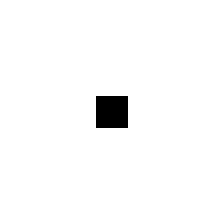

In [7]:
transforms.ToPILImage()(mask.detach().cpu())

In [8]:
for data in train_loader:
    images = data[0].to(device)
    for i in images[0]:
        asdf = i
        break
    break
        
    

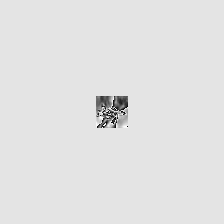

In [9]:
transforms.ToPILImage()(asdf.detach().cpu())

In [10]:
#Training loop
num_epochs = 20
steps_per_epoch = len(train_loader)

for epoch in range(num_epochs):

    if epoch == 0:
      print('Training has started')

    
    total_loss = 0.0

    for i, data in enumerate(train_loader):
      images = data[0].to(device) #grabbing images from the data
      labels = data[1].to(device) #grabbing labels from the data

      images = images + torch.tanh(program*mask) #additive contribution to the image

      outputs = model(images) # see what resnet classifies
      outputs = outputs[:,:num_classes] #only care about first 10 cause MNIST only has 10 classes.
     
      loss = loss_criterion(outputs, labels) # find loss
      loss.backward() # backwards pass
      optimizer.step() #update weights
      optimizer.zero_grad()


      total_loss += loss.item() #calculate total loss
      
      if(i+1)%(steps_per_epoch/2) == 0:
        print(f'Epoch {epoch+1}/{num_epochs},  Step {i+1}/{steps_per_epoch},  Loss:  {loss.item()},  Avg Loss for Epoch:  {total_loss/(i+1)}')
    lr_scheduler.step() # adjusting learning rate

Training has started
Epoch 1/20,  Step 500/1000,  Loss:  1.6567035913467407,  Avg Loss for Epoch:  1.798110729455948
Epoch 1/20,  Step 1000/1000,  Loss:  1.6638572216033936,  Avg Loss for Epoch:  1.661605710029602
Epoch 2/20,  Step 500/1000,  Loss:  1.5564335584640503,  Avg Loss for Epoch:  1.4011790846586227
Epoch 2/20,  Step 1000/1000,  Loss:  1.3769707679748535,  Avg Loss for Epoch:  1.3698639314174652
Epoch 3/20,  Step 500/1000,  Loss:  1.2329230308532715,  Avg Loss for Epoch:  1.2834218474626542
Epoch 3/20,  Step 1000/1000,  Loss:  1.222278118133545,  Avg Loss for Epoch:  1.2644389971494674
Epoch 4/20,  Step 500/1000,  Loss:  0.9688772559165955,  Avg Loss for Epoch:  1.213598769426346
Epoch 4/20,  Step 1000/1000,  Loss:  1.1230087280273438,  Avg Loss for Epoch:  1.2077184341549874
Epoch 5/20,  Step 500/1000,  Loss:  1.1963670253753662,  Avg Loss for Epoch:  1.1722366299629212
Epoch 5/20,  Step 1000/1000,  Loss:  0.9866178631782532,  Avg Loss for Epoch:  1.1770107309222222
Epoch 6/

In [11]:
# testing
with torch.no_grad(): 

  total_loss = 0.0
  total_steps = len(test_loader)
  total = 0
  total_correct = 0


  for data in test_loader:
      images = data[0].to(device)
      labels = data[1].to(device) 

      images = images + torch.tanh(program*mask)
      outputs = model(images)
      outputs = outputs[:,:num_classes]

      preds = torch.argmax(torch.softmax(outputs, dim =1), dim = 1) #grabs index of highest pred

      total_correct += torch.sum(preds==labels).item() 
      total+= labels.shape[0]




In [12]:
acc = (total_correct/total) * 100.0
print(f'Accuracy: {acc:.4f}')

Accuracy: 61.2800


In [13]:
torch.save({'program':program, 'mask':mask}, 'inception_v3_adversarial_CIFAR10.pth')

In [14]:
state = torch.load('inception_v3_adversarial_CIFAR10.pth')
program = state['program']
mask = state['mask']

In [15]:
transforms.ToPILImage()(program.detach().cpu())
x,y = train_dataset[0]


torch.max(x)

x.shape



def imshow(img):
    return transforms.ToPILImage()(img.detach().cpu())

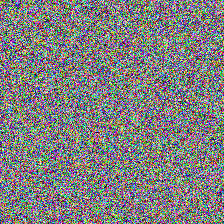

In [16]:
imshow(program)